# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 2

In this project, the goal is to design and implement an optimizer. For better understanding, the following mathematical explanations are provided.

The process of learning the parameters $\theta$ of a deep network $f$ with conventional gradient descent algorithms (such as $\texttt{SGD}$) can be represented by the relationship (1) given the training inputs $x$:

\begin{equation}
	\theta_{i+1} = \theta_i - \alpha \nabla f(x; \theta_i)
\end{equation}

Now, if we assume that instead of using a fixed learning rate $\alpha$, we use a function (deep network) such as $g$ with learnable parameters $\phi$, we can rewrite relationship (1) as:

\begin{equation}
	\theta_{i+1} = \theta_i + g(\nabla f(x; \theta_i); \phi)
\end{equation}

Finally, we can also consider the parameter $\theta_i$​ as another input to g and rewrite relationship (2) as follows:
\begin{equation}
	\theta_{i+1} = g(\nabla f(x; \theta_i), \theta_i; \phi)
\end{equation}

It can thus be concluded that if we consider the function $g$ as a recurrent network (such as $\texttt{LSTM}$ or $\texttt{GRU}$), it is possible to present an optimizer, and the entire mentioned process can be carried out with two loops (outer and inner). The architecture of this process is outlined below. Each iteration of the outer loop is equivalent to one epoch for training the network $g$, and each iteration of the inner loop is equivalent to generating one training data for the network $g$.

In this question, the goal is to design and implement an optimizer based on the above explanations:

### Part1:
Consider the first dataset ($\texttt{dataset\_1.csv}$) as the training set, display it (plot it), and then shuffle and divide it into 50 subsets such that each class has an equal number of samples and the selection of samples is done with uniform probability. 
Now, design an arbitrary $\texttt{MLP}$ network and name it $f$ such that $f_1,f_2,f_3,...$ are $\texttt{MLP}$ networks with the same architecture but with different initializations each time.

Next, design a recurrent network based on $\texttt{GRU}$ and name it $g$, whose task is to optimize the learnable weights of the $f$ architecture for the given objective. Using the 50 subsets created in the previous step, train the network g. Explain the implementation process of the training, the designed architecture, and other necessary details completely. 
Note that for each inner loop (in each outer loop), a completely new initialization for the $f$ network takes place. In each subset, the training to testing ratio is 2:8.


### Part2:
Load the second dataset ($\texttt{dataset\_2.csv}$), display it (plot it), and explain the differences between it and the first dataset. Then, divide it into 30 subsets similar to the explanation in part 1. Finally, for each subset, consider a network with the $f$ architecture and optimize it with the $g$ network. Report the average accuracy and error.


### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim

### Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Read dataset and data visualization

In [3]:
df = pd.read_csv("../inputs/dataset_1.csv")

# shuffling dataset
df = shuffle(df)

# split dataset into the inputs x and the outputs y (labels)
X = df[['x', 'y']]
y = df['label']

print("shape of data frame is:", df.shape)
df

shape of data frame is: (100000, 3)


,x,y,label
45089,73.46281,62.60531,0.0
81101,-64.70864,-37.63372,0.0
9474,-69.99582,-4.58385,0.0
42881,-20.40946,102.57979,0.0
45989,-40.61369,16.67236,1.0
...,...,...,...
92339,-18.14189,13.13609,0.0
36902,46.58511,-43.49732,1.0
13738,40.37781,63.62238,1.0
37846,67.03522,22.81052,1.0


### Convert data to pytorch tensors

In [4]:
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device).view(-1, 1)

print("Training set size:", len(X_tensor))
X_tensor

Training set size: 100000


tensor([[ 73.4628,  62.6053],
        [-64.7086, -37.6337],
        [-69.9958,  -4.5838],
        ...,
        [ 40.3778,  63.6224],
        [ 67.0352,  22.8105],
        [ 34.8092,  68.9705]], device='cuda:0')

### Split classes

In [5]:
class0 = torch.cat((X_tensor[y_tensor.flatten() == 0], y_tensor[y_tensor.flatten() == 0]), dim=1)
class1 = torch.cat((X_tensor[y_tensor.flatten() == 1], y_tensor[y_tensor.flatten() == 1]), dim=1)

### Plot dataset

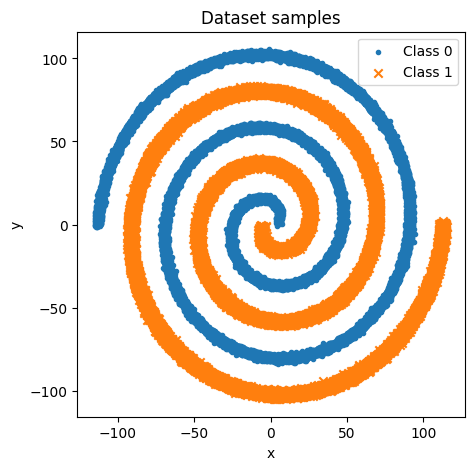

In [6]:
plt.figure(figsize=(5, 5))

plt.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

### Split dataset into the 50 subsets

In [7]:
# determine number of samples per subset
num_subsets = 50
num_samples_per_class = min(len(class0), len(class1)) // num_subsets

subsets = []
for _ in range(num_subsets):
    indices_class0 = torch.randperm(len(class0))[:num_samples_per_class]
    indices_class1 = torch.randperm(len(class1))[:num_samples_per_class]
    
    subset_class0 = class0[indices_class0]
    subset_class1 = class1[indices_class1]
    
    subset = torch.cat((subset_class0, subset_class1), dim=0)
    subsets.append(subset)

for i, subset in enumerate(subsets):
    print(f"subset {i+1}: {subset.shape}")

subset 1: torch.Size([2000, 3])
subset 2: torch.Size([2000, 3])
subset 3: torch.Size([2000, 3])
subset 4: torch.Size([2000, 3])
subset 5: torch.Size([2000, 3])
subset 6: torch.Size([2000, 3])
subset 7: torch.Size([2000, 3])
subset 8: torch.Size([2000, 3])
subset 9: torch.Size([2000, 3])
subset 10: torch.Size([2000, 3])
subset 11: torch.Size([2000, 3])
subset 12: torch.Size([2000, 3])
subset 13: torch.Size([2000, 3])
subset 14: torch.Size([2000, 3])
subset 15: torch.Size([2000, 3])
subset 16: torch.Size([2000, 3])
subset 17: torch.Size([2000, 3])
subset 18: torch.Size([2000, 3])
subset 19: torch.Size([2000, 3])
subset 20: torch.Size([2000, 3])
subset 21: torch.Size([2000, 3])
subset 22: torch.Size([2000, 3])
subset 23: torch.Size([2000, 3])
subset 24: torch.Size([2000, 3])
subset 25: torch.Size([2000, 3])
subset 26: torch.Size([2000, 3])
subset 27: torch.Size([2000, 3])
subset 28: torch.Size([2000, 3])
subset 29: torch.Size([2000, 3])
subset 30: torch.Size([2000, 3])
subset 31: torch.Si

### Print sub datasets

In [8]:
for i, loader in enumerate(subsets):
    print(f"Subset {i+1}:")
    print(loader)
    print('-' * 50)

Subset 1:
tensor([[ 90.3425, -13.8065,   0.0000],
        [ 12.2387,  99.9308,   0.0000],
        [-62.3302, -34.1428,   0.0000],
        ...,
        [ 55.9775, -35.9741,   1.0000],
        [-73.2319, -62.9040,   1.0000],
        [ 16.9411, -58.0383,   1.0000]], device='cuda:0')
--------------------------------------------------
Subset 2:
tensor([[ 47.4137,  85.5787,   0.0000],
        [ 22.5193,  98.6952,   0.0000],
        [ 46.2943,  -0.9892,   0.0000],
        ...,
        [-34.0279, -94.8296,   1.0000],
        [-10.1396,  78.8019,   1.0000],
        [100.5447, -46.0529,   1.0000]], device='cuda:0')
--------------------------------------------------
Subset 3:
tensor([[-70.1931, -16.6532,   0.0000],
        [ 17.1724,  98.4662,   0.0000],
        [ 45.4131,  -9.2522,   0.0000],
        ...,
        [ 33.0705, -98.8601,   1.0000],
        [-37.0723, -92.5507,   1.0000],
        [ 99.8655, -49.4600,   1.0000]], device='cuda:0')
--------------------------------------------------
Subs

### Design MLP network

* Input layer: 2 neurons
* Hidden layer1: 128 neurons
* Hidden layer2: 64 neurons
* output layer: 1 neurons
* Activation function: ReLU

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create 50 instances of the MLP network with different initializations

In [10]:
num_networks = 50
networks = [MLP().to(device) for _ in range(num_networks)]
networks

[MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_feature

### Define the GRU-based RNN (G)

In [11]:
class GRUOptimizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUOptimizer, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

### Initialize the GRU optimizer network

In [12]:
input_size = 2
hidden_size = 128
output_size = 1
gru_optimizer = GRUOptimizer(input_size, hidden_size, output_size).to(device)

optimizer_gru = optim.Adam(gru_optimizer.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Define evaluation function

In [13]:
def evaluate_model(f, data_loader):
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = f(X_batch)
            loss = criterion(outputs, y_batch)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = 100 * correct / total
    error = loss.item()
    return accuracy, error

### Training phase

In [14]:
accuracies = []
errors = []

for subset in subsets:
    # split subset into training and testing sets with 2:8 ratio
    subset = subset.cpu().numpy()
    train_size = int(0.2 * len(subset))
    train_data, test_data = train_test_split(subset, train_size=train_size, random_state=42)
    
    train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
    test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
    
    train_X, train_y = train_data[:, :2], train_data[:, 2].view(-1, 1)
    test_X, test_y = test_data[:, :2], test_data[:, 2].view(-1, 1)
    
    # create DataLoader for the test set
    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # outer loop
    for _ in range(10):
        f = MLP().to(device)
        optimizer_f = optim.SGD(f.parameters(), lr=0.01)
        
        hidden = torch.zeros(1, 1, hidden_size).to(device)
        # inner loop
        for epoch in range(5):
            optimizer_f.zero_grad()
            
            # forward pass
            outputs = f(train_X)
            loss = criterion(outputs, train_y)
            
            # backward pass
            loss.backward()
            
            # get the gradients
            gradients = []
            params = []
            for param in f.parameters():
                gradients.append(param.grad.view(-1, 1))
                params.append(param.view(-1, 1))
            gradients = torch.cat(gradients).view(1, -1, 1)
            params = torch.cat(params).view(1, -1, 1)
            
            # concatenate gradients and parameters
            grad_param_cat = torch.cat((gradients, params), dim=2).to(device)
            
            # update parameters using GRU optimizer
            updates, hidden = gru_optimizer(grad_param_cat, hidden)
            updates = updates.view(-1)
            
            # apply updates to the parameters
            with torch.no_grad():
                for param, update in zip(f.parameters(), updates):
                    param -= 0.01 * update
            
            # set zero the gradients after updating
            for param in f.parameters():
                param.grad = None
        
        # evaluate network on testing set data
        f.eval()
        accuracy, error = evaluate_model(f, test_loader)
        accuracies.append(accuracy)
        errors.append(error)

# calculate average accuracy and error
avg_accuracy = sum(accuracies) / len(accuracies)
avg_error = sum(errors) / len(errors)

print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Error: {avg_error:.4f}")

Average Accuracy: 49.99
Average Error: 2.2704


## Part 2:

### Read and Plot dataset 2

In [15]:
df_2 = pd.read_csv("../inputs/dataset_2.csv")

# shuffling dataset
df_2 = shuffle(df_2)

# split dataset into the inputs x and the outputs y (labels)
X_2 = df_2[['x', 'y']]
y_2 = df_2['label']

print("shape of data frame is:", df_2.shape)
df_2

shape of data frame is: (60000, 3)


,x,y,label
32992,-6.83735,15.59275,0.0
54004,-14.62318,-29.97327,0.0
10529,7.97737,32.53706,1.0
31980,-17.03517,-77.61633,0.0
23985,48.94415,59.16045,1.0
...,...,...,...
10881,25.57032,47.04603,0.0
14668,51.60917,-37.17503,1.0
32864,-17.30422,-76.30360,0.0
58328,-84.93697,24.73012,1.0


In [16]:
X2_tensor = torch.tensor(X_2.values, dtype=torch.float32).to(device)
y2_tensor = torch.tensor(y_2.values, dtype=torch.float32).to(device).view(-1, 1)

print("Training set size:", len(X2_tensor))
X2_tensor

Training set size: 60000


tensor([[ -6.8373,  15.5927],
        [-14.6232, -29.9733],
        [  7.9774,  32.5371],
        ...,
        [-17.3042, -76.3036],
        [-84.9370,  24.7301],
        [-24.6106,  -7.7569]], device='cuda:0')

In [17]:
class0_2= torch.cat((X2_tensor[y2_tensor.flatten() == 0], y2_tensor[y2_tensor.flatten() == 0]), dim=1)
class1_2 = torch.cat((X2_tensor[y2_tensor.flatten() == 1], y2_tensor[y2_tensor.flatten() == 1]), dim=1)

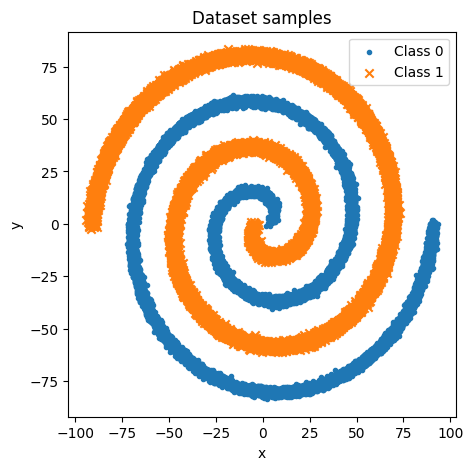

In [18]:
plt.figure(figsize=(5, 5))

plt.scatter(class0_2[:, 0].cpu().numpy(), class0_2[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1_2[:, 0].cpu().numpy(), class1_2[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

### Divide into 30 Subsets

In [19]:
# Determine number of samples per subset
num_subsets_2 = 30
num_samples_per_class_2 = min(len(class0_2), len(class1_2)) // num_subsets_2

subsets_2 = []
for _ in range(num_subsets_2):
    indices_class0_2 = torch.randperm(len(class0_2))[:num_samples_per_class_2]
    indices_class1_2 = torch.randperm(len(class1_2))[:num_samples_per_class_2]
    
    subset_class0_2 = class0_2[indices_class0_2]
    subset_class1_2 = class1_2[indices_class1_2]
    
    subset_2 = torch.cat((subset_class0_2, subset_class1_2), dim=0)
    subsets_2.append(subset_2)

for i, subset in enumerate(subsets_2):
    print(f"subset {i+1}: {subset.shape}")

subset 1: torch.Size([2000, 3])
subset 2: torch.Size([2000, 3])
subset 3: torch.Size([2000, 3])
subset 4: torch.Size([2000, 3])
subset 5: torch.Size([2000, 3])
subset 6: torch.Size([2000, 3])
subset 7: torch.Size([2000, 3])
subset 8: torch.Size([2000, 3])
subset 9: torch.Size([2000, 3])
subset 10: torch.Size([2000, 3])
subset 11: torch.Size([2000, 3])
subset 12: torch.Size([2000, 3])
subset 13: torch.Size([2000, 3])
subset 14: torch.Size([2000, 3])
subset 15: torch.Size([2000, 3])
subset 16: torch.Size([2000, 3])
subset 17: torch.Size([2000, 3])
subset 18: torch.Size([2000, 3])
subset 19: torch.Size([2000, 3])
subset 20: torch.Size([2000, 3])
subset 21: torch.Size([2000, 3])
subset 22: torch.Size([2000, 3])
subset 23: torch.Size([2000, 3])
subset 24: torch.Size([2000, 3])
subset 25: torch.Size([2000, 3])
subset 26: torch.Size([2000, 3])
subset 27: torch.Size([2000, 3])
subset 28: torch.Size([2000, 3])
subset 29: torch.Size([2000, 3])
subset 30: torch.Size([2000, 3])


### Optimizing $f$ with $g$ optimizer with 30 subdataset 2

In [20]:
accuracies_2 = []
errors_2 = []

for subset in subsets_2:
    # split subset into training and testing sets with 2:8 ratio
    subset = subset.cpu().numpy()
    train_size = int(0.2 * len(subset))
    train_data, test_data = train_test_split(subset, train_size=train_size, random_state=42)
    
    train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
    test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
    
    train_X, train_y = train_data[:, :2], train_data[:, 2].view(-1, 1)
    test_X, test_y = test_data[:, :2], test_data[:, 2].view(-1, 1)
    
    # create DataLoader for the test set
    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # outer loop
    for _ in range(10):
        f = MLP().to(device)
        optimizer_f = optim.SGD(f.parameters(), lr=0.01)
        
        hidden = torch.zeros(1, 1, hidden_size).to(device)
        # inner loop
        for epoch in range(5):
            optimizer_f.zero_grad()
            
            # forward pass
            outputs = f(train_X)
            loss = criterion(outputs, train_y)
            
            # backward pass
            loss.backward()
            
            # get the gradients
            gradients = []
            params = []
            for param in f.parameters():
                gradients.append(param.grad.view(-1, 1))
                params.append(param.view(-1, 1))
            gradients = torch.cat(gradients).view(1, -1, 1)
            params = torch.cat(params).view(1, -1, 1)
            
            # concatenate gradients and parameters
            grad_param_cat = torch.cat((gradients, params), dim=2).to(device)
            
            # update the parameters using GRU optimizer
            updates, hidden = gru_optimizer(grad_param_cat, hidden)
            updates = updates.view(-1)
            
            # apply updates to the parameters
            with torch.no_grad():
                for param, update in zip(f.parameters(), updates):
                    param -= 0.01 * update
            
            # set zero gradients after updating
            for param in f.parameters():
                param.grad = None
        
        # evaluate network on testing set data
        f.eval()
        accuracy, error = evaluate_model(f, test_loader)
        accuracies_2.append(accuracy)
        errors_2.append(error)

# calculate average accuracy and error
avg_accuracy_2 = sum(accuracies_2) / len(accuracies_2)
avg_error_2 = sum(errors_2) / len(errors_2)

print(f"Average Accuracy for dataset_2: {avg_accuracy_2:.2f}")
print(f"Average Error for dataset_2: {avg_error_2:.4f}")

Average Accuracy for dataset_2: 49.96
Average Error for dataset_2: 1.8790
